# Penguin vs Turtle image classification

We have the task of automatically determine if an image contains a Turtle or a Penguin:
- We use the machine learning way of doing it, collect images from both classes
- We use Tensorflow to build the classification model. TensorFlow is an open-source machine learning framework developed by Google. It is widely used for tasks such as deep learning, neural networks, and numerical computations.

In [1]:
import pandas as pd
import numpy as np
from numpy import random
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time
from tqdm import tqdm
from sklearn.metrics import f1_score
#from IPython.display import YouTubeVideo
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

It is really important to configure GPUs if you have. If not, training networks can take a really long time!

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print('GPU', tf.test.gpu_device_name(), 'configured')

GPU /device:GPU:0 configured


Load the data. I split the images in two folders, one for training the model and other one for evaluating the models with images that it has not seen before.

In [3]:
train_base_path = "../large_datasets/penguin_turtles/train"
train_annot_file_name = "../large_datasets/penguin_turtles/train_annotations"
test_base_path = "../large_datasets/penguin_turtles/valid"
test_annot_file_name = "../large_datasets/penguin_turtles/valid_annotations"
train_file_names = [os.path.join(train_base_path, f) for f in os.listdir(train_base_path)]
valid_file_names = [os.path.join(train_base_path, f) for f in os.listdir(test_base_path)]

Lets display some images

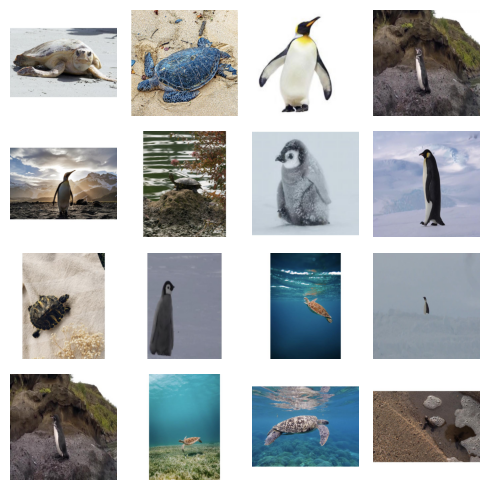

In [4]:
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Assuming you have a list of image file names called 'image_files'
image_files = train_file_names[:16]

# Calculate the number of rows and columns for the grid
n_rows = 4
n_cols = 4

# Create a new figure with the desired grid size
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5, 5))

# Iterate over the image files and display them in the grid
for i, ax in enumerate(axes.flatten()):
    if i < len(image_files):
        img = mpimg.imread(image_files[i])
        ax.imshow(img)
        ax.axis('off')
    else:
        ax.axis('off')

# Adjust the spacing and layout
plt.tight_layout()

# Display the figure
plt.show()

Seed everything to reproduce results for future use cases

In [5]:
def seed_everything(seed=42):
    # Seed value for TensorFlow
    tf.random.set_seed(seed)
    
    # Seed value for NumPy
    np.random.seed(seed)
    
    # Seed value for Python's random library
    random.seed(seed)
    
    # Force TensorFlow to use single thread
    # Multiple threads are a potential source of non-reproducible results.
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )

    # Make sure that TensorFlow uses a deterministic operation wherever possible
    tf.compat.v1.set_random_seed(seed)

    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

seed_everything()

Read the annotation file.

- Note: Every dataset available in internet might have a different way to store and annotate the images

In [6]:
train_anno=pd.read_json(train_annot_file_name)
train_anno.head()

,id,image_id,category_id,bbox,area,segmentation,iscrowd
0,0,0,1,"[119, 25, 205, 606]",124230,[],0
1,1,1,1,"[131, 82, 327, 440]",143880,[],0
2,2,2,2,"[225, 298, 198, 185]",36630,[],0
3,3,3,2,"[468, 109, 172, 193]",33196,[],0
4,4,4,1,"[14, 242, 611, 154]",94094,[],0


Lets check the number of classes:

In [7]:
# lets see how many classes are present in the category id
classes=list(train_anno['category_id'].unique())
classes

[1, 2]

Transform datasets to my selected format

In [8]:
def transform_dataframe(df):
    df=df.drop(['id', 'bbox', 'area', 'segmentation', 'iscrowd'], axis =1)
    # lets replace the numeric class designation with the test name of the class
    df['category_id']=df['category_id'].replace({1:'Penguin',2:'Turtle'})
    df.columns=['filepaths', 'labels']
    df['filepaths'] = df['filepaths'].apply(
        lambda x: os.path.join(train_base_path, f"image_id_{str(x).zfill(3)}.jpg"))
    return df

In [9]:
train_df = transform_dataframe(train_anno)
train_df.head()

,filepaths,labels
0,../large_datasets/penguin_turtles/train/image_id_000.jpg,Penguin
1,../large_datasets/penguin_turtles/train/image_id_001.jpg,Penguin
2,../large_datasets/penguin_turtles/train/image_id_002.jpg,Turtle
3,../large_datasets/penguin_turtles/train/image_id_003.jpg,Turtle
4,../large_datasets/penguin_turtles/train/image_id_004.jpg,Penguin


In [10]:
train_df, valid_df = train_test_split(train_df, test_size=0.3, random_state=42)

Do the same with testing data

In [11]:
test_df=pd.read_json(test_annot_file_name)
test_df = transform_dataframe(test_df)

Lets check the balance in the number of elements per class

In [12]:
balance=list(train_df['labels'].value_counts())
print (balance)

[178, 172]


The train set is balance and has an adequate number of images for classification

Lets create generators for the three dataframes

In [13]:
img_size=(224,224) # image size
bs=40 # batch size
t_gen=ImageDataGenerator(horizontal_flip=True) # generator for training for data augmentation
gen=ImageDataGenerator() # generator for validation and test 
train_gen=t_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   color_mode='rgb',batch_size=bs, shuffle=True, seed=123,
                                   class_mode= 'categorical')
valid_gen=gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   color_mode='rgb',batch_size=bs, shuffle=False, seed=123,
                                   class_mode= 'categorical')
test_gen=gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   color_mode='rgb',batch_size=bs, shuffle=False, seed=123,
                                   class_mode= 'categorical')


Found 350 validated image filenames belonging to 2 classes.
Found 150 validated image filenames belonging to 2 classes.
Found 72 validated image filenames belonging to 2 classes.


Lets create now the neural network. In this example we use transfer learning using as base the EfficientNetB0 model.

In [14]:
class_count=2 # number of classes
lr= .001 # learning rate
img_shape=(224,224,3) # shape of color images
base_model=tf.keras.applications.EfficientNetV2B0(include_top=False, weights="imagenet",
                                                   input_shape=img_shape, pooling='max')        
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x = Dropout(rate=.4, seed=123)(x)       
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)

Compile the model, defining the learner, the loss and quality metrics

In [15]:
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 

Lets define 2 callbacks , reduce learning rate on plateau and early stopping

In [16]:
rlronp=tf.keras.callbacks.ReduceLROnPlateau( monitor="val_loss", factor=0.4,  patience=2,
                                            verbose=1)
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4,restore_best_weights=True)
callbacks=[rlronp, estop]

Now lets train the model!

In [17]:
epochs=20
history=model.fit(x=train_gen,   epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
                   validation_steps=None,  shuffle=True,  initial_epoch=0) # train the model

Epoch 1/20


2024-01-23 10:14:15.206242: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


9/9 [==============================] - 26s 661ms/step - loss: 7.6171 - accuracy: 0.8771 - val_loss: 9.2429 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 2/20
9/9 [==============================] - 2s 185ms/step - loss: 6.6983 - accuracy: 0.9800 - val_loss: 7.9773 - val_accuracy: 0.9533 - lr: 0.0010
Epoch 3/20
9/9 [==============================] - 2s 187ms/step - loss: 6.0745 - accuracy: 0.9886 - val_loss: 6.6785 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 4/20
9/9 [==============================] - 2s 186ms/step - loss: 5.5142 - accuracy: 0.9943 - val_loss: 5.8951 - val_accuracy: 0.9733 - lr: 0.0010
Epoch 5/20
9/9 [==============================] - 2s 187ms/step - loss: 5.0167 - accuracy: 0.9943 - val_loss: 5.2631 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 6/20
9/9 [==============================] - 2s 193ms/step - loss: 4.6205 - accuracy: 0.9857 - val_loss: 4.7465 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 7/20
9/9 [==============================] - 2s 192ms/step - loss: 4.2437 - accuracy: 0

Lets define a function to plot the training data. (copied from Internet)

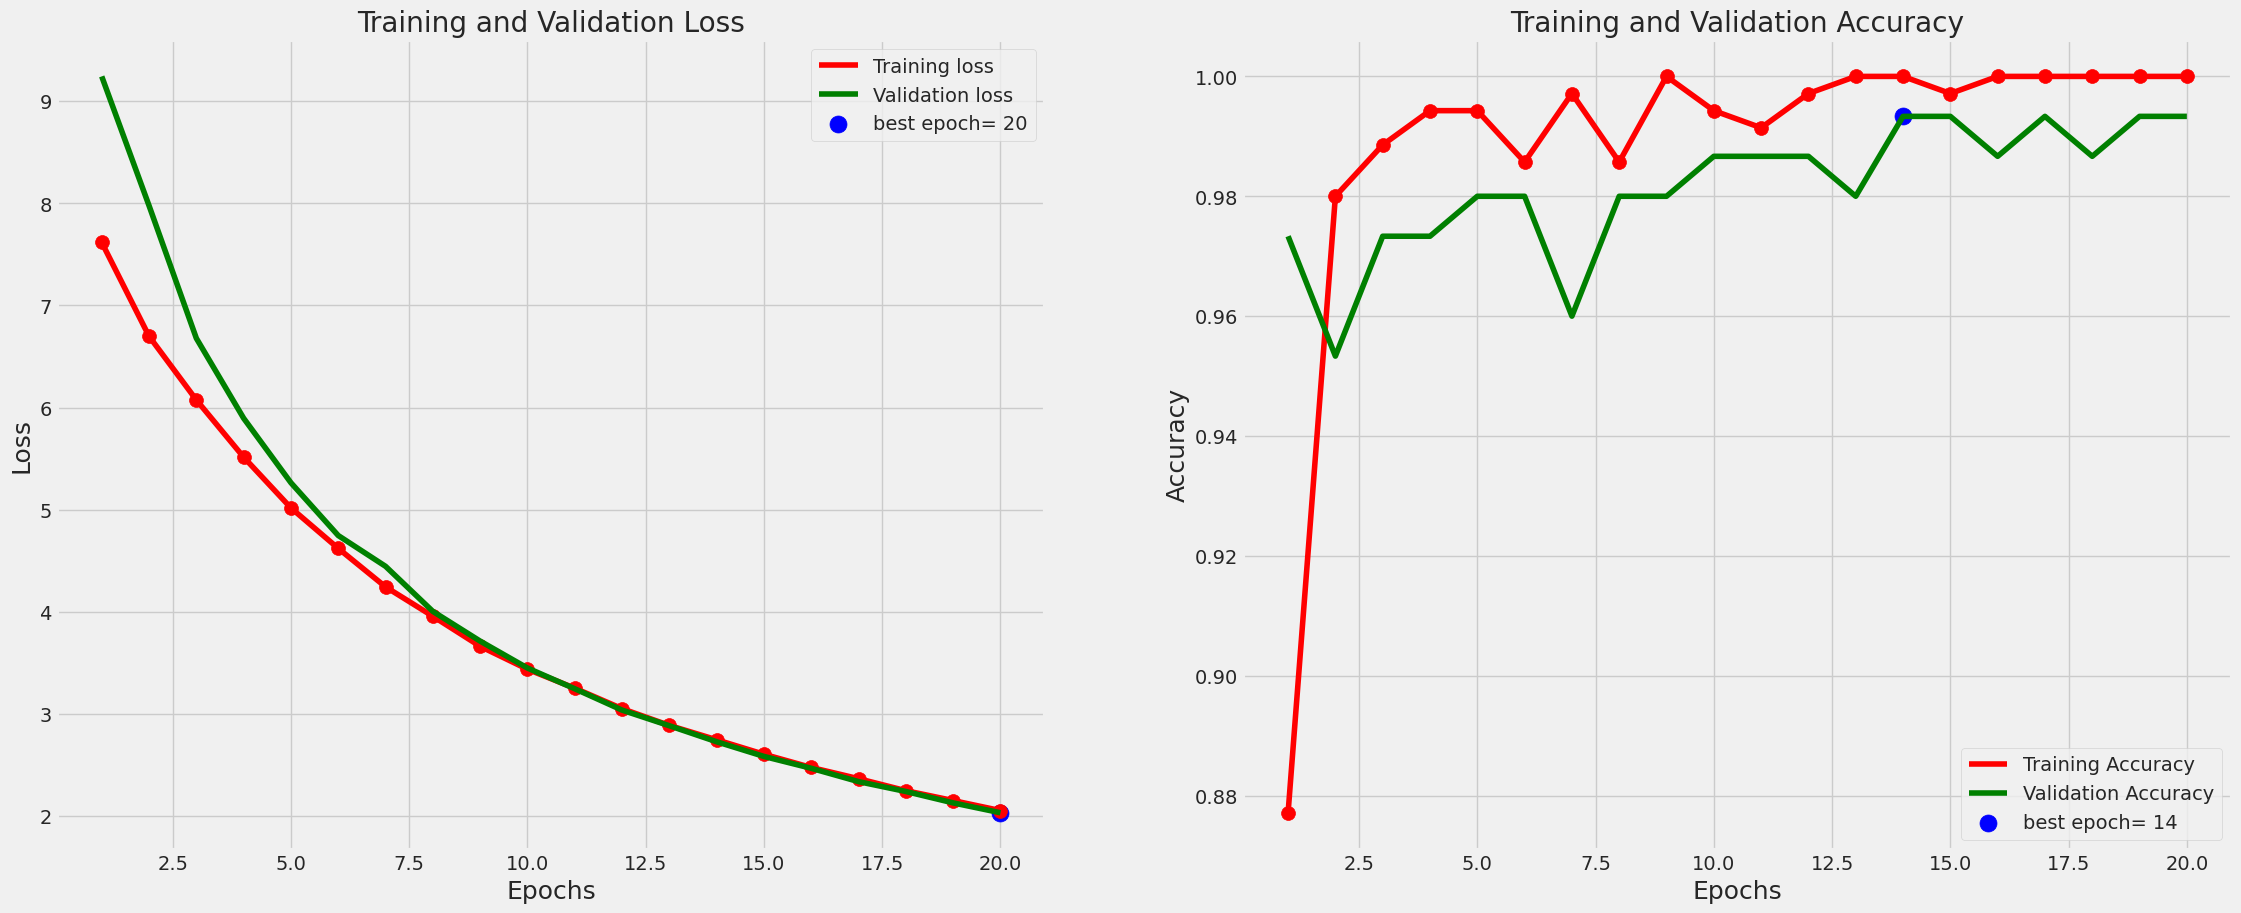

In [18]:
def tr_plot(tr_data):
    start_epoch=0
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']      
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]    
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)     
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')    
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()    
    plt.tight_layout    
    plt.show()
    return 

tr_plot(history)

We ended up with a validation accuracy over 98% so the model is performing correctly.

Lets make predictions on the test set and produce a confusion matrix and a classification report

2/2 [==============================] - 2s 1s/step
There were 27 errors in 72 tests for an accuracy of  62.50 and an F1 score of  62.43


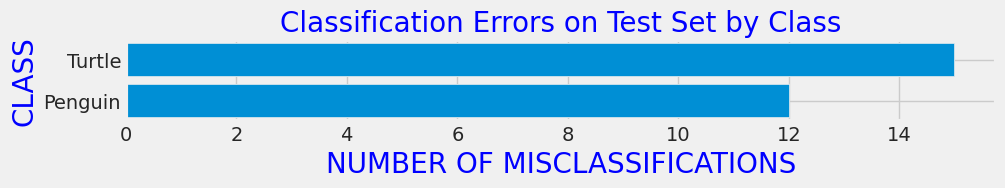

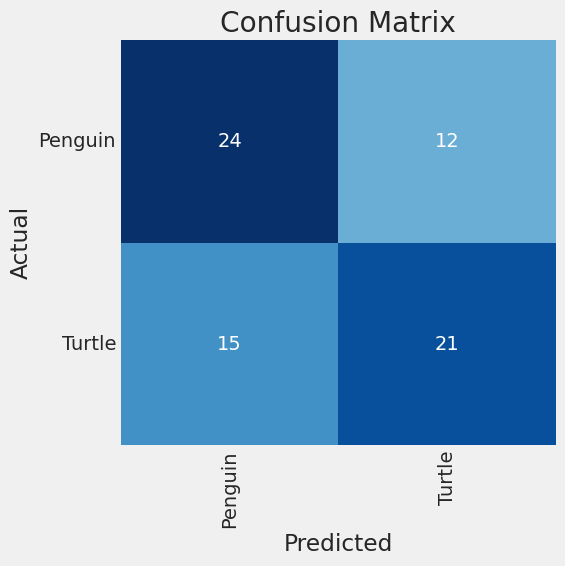

Classification Report:
----------------------
               precision    recall  f1-score   support

     Penguin     0.6154    0.6667    0.6400        36
      Turtle     0.6364    0.5833    0.6087        36

    accuracy                         0.6250        72
   macro avg     0.6259    0.6250    0.6243        72
weighted avg     0.6259    0.6250    0.6243        72



In [19]:
def predictor(model,test_gen):
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    preds=model.predict(test_gen, verbose=1)
    errors=0
    test_count =len(preds)
    misclassified_classes=[]
    misclassified_files=[]
    misclassified_as = []
    pred_indices=[]
    for i, p in enumerate (preds):
        pred_index=np.argmax(p)
        pred_indices.append(pred_index)
        true_index= test_gen.labels[i]    
        if  pred_index != true_index:        
            errors +=1        
            misclassified_classes.append(classes[true_index])
            misclassified_as.append(classes[pred_index])
            file=test_gen.filenames[i]
            split=file.split('/')
            L=len(split)           
            f=split[L-2] +' '+ split[L-1]  
            misclassified_files.append(f)

    accuracy = (test_count-errors)*100/test_count
    ytrue=np.array(test_gen.labels)
    ypred=np.array(pred_indices)
    f1score=f1_score(ytrue, ypred, average='weighted')* 100
    msg=f'There were {errors} errors in {test_count} tests for an accuracy of {accuracy:6.2f} and an F1 score of {f1score:6.2f}'
    print (msg) 
    misclassified_classes=sorted(misclassified_classes)
    if len(misclassified_classes) > 0:
        misclassifications=[]
        for klass in misclassified_classes:
            mis_count=misclassified_classes.count(klass)
            misclassifications.append(mis_count)
        unique=len(np.unique(misclassified_classes)) 
        if unique==1:
            height=int(unique)
        else:
            height =int(unique/2)
        plt.figure(figsize=(10, height))
        plt.style.use('fivethirtyeight')
        plt.barh(misclassified_classes, misclassifications )
        plt.title( 'Classification Errors on Test Set by Class', fontsize=20, color='blue')
        plt.xlabel('NUMBER OF MISCLASSIFICATIONS', fontsize=20, color='blue')
        plt.ylabel('CLASS', fontsize=20, color='blue')
        plt.show()
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(5, 5))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
        clr = classification_report(ytrue, ypred, target_names=classes, digits= 4) # create classification report
        print("Classification Report:\n----------------------\n", clr)
    return f1score, misclassified_files

f1score, misclassified_files= predictor(model,test_gen)

Save the model for later reuse

In [22]:
def save_model(model,subject, classes, img_size, f1score, working_dir):    
    name=f'{subject}-{str(len(classes))}-({str(img_size[0])} X {str(img_size[1])})- {f1score:5.2f}.h5'    
    model_save_loc=os.path.join(working_dir, name)
    try:
        model.save(model_save_loc)        
        msg= f'model was saved as {model_save_loc}'        
    except:
        msg='model can not be saved due to tensorflow 2.10.0 or higher due to bug for efficientnet models' 
    print (msg)
    
subject='penguins vs turtles'
working_dir=r'data'
save_model(model,subject, classes, img_size, f1score, working_dir)

model was saved as data/penguins vs turtles-2-(224 X 224)- 62.43.h5


## Later use of the model

In [23]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from IPython.display import display, Image

# Load the saved model
model = load_model('data/penguins vs turtles-2-(224 X 224)- 62.43.h5')

In [24]:
class_names = {0:'Penguin',1:'Turtle'}

# Load and preprocess the image
image_files = []
image_labels = []
for image_path in valid_file_names[:20]:
    image = load_img(image_path, target_size=(224, 224))  # Adjust the target_size as per your model's input shape
    image_files.append(image)
    image_array = img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0)

    # Make predictions
    predictions = model.predict(image_array)
    predicted_class = np.argmax(predictions[0])
    image_labels.append(class_names[predicted_class])



1/1 [==============================] - 0s 20ms/step


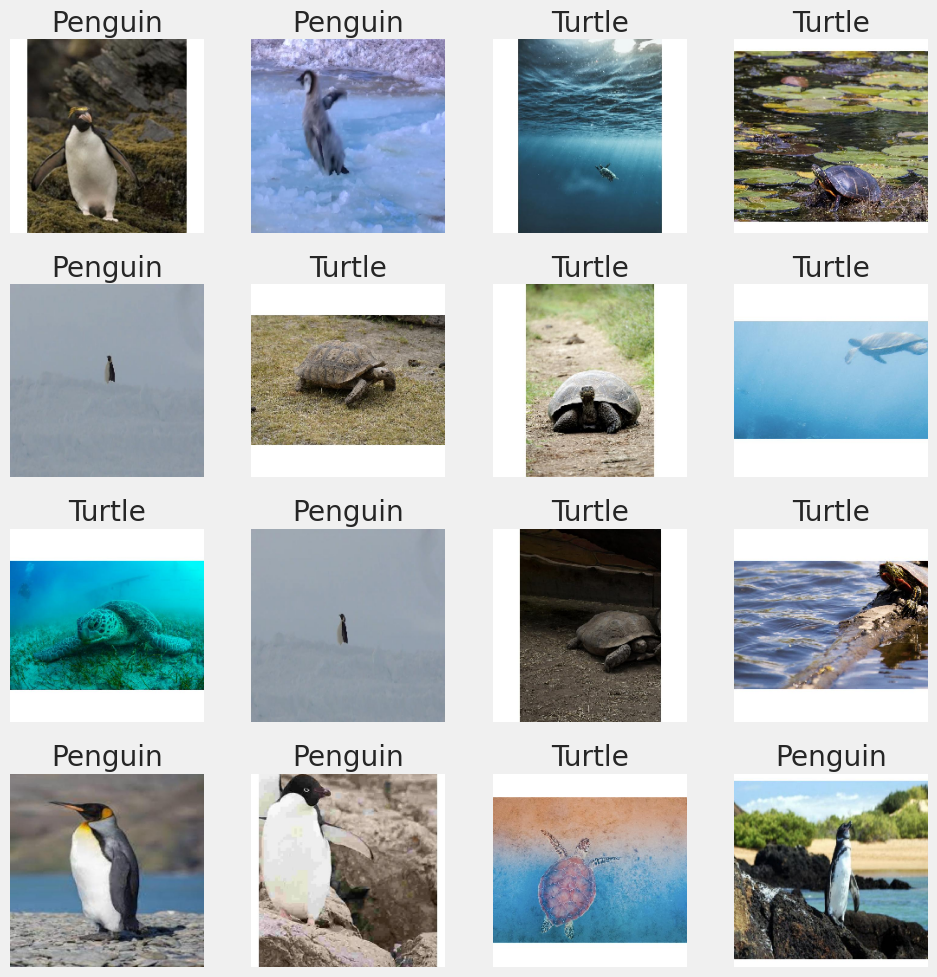

In [25]:
# Calculate the number of rows and columns for the grid
n_rows = 4
n_cols = 4

# Create a new figure with the desired grid size
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))

# Iterate over the image files and display them in the grid with labels
for i, ax in enumerate(axes.flatten()):
    if i < len(image_files):
        ax.imshow(image_files[i])
        ax.set_title(image_labels[i])
        ax.axis('off')
    else:
        ax.axis('off')

# Adjust the spacing and layout
plt.tight_layout()

# Display the figure
plt.show()